In [1]:
import numpy as np

import dreamcoder as dc
from dreamcoder.domains.quantum_algorithms.primitives import *
from dreamcoder.domains.quantum_algorithms.tasks import *

import time
from tqdm import trange
import random

%autoreload 2
%load_ext line_profiler

### Testing some circuits

In [2]:

n_qubit = 2
full_circuit = [n_qubit,
           [["cnot", 0, 1],
           ["swap", 0, 1],
           ["hadamard", 1]]
]

In [3]:
tensor = eye(n_qubit)
tensor_to_mat(swap(cnot(tensor,0,1),0,1))

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float16)

In [4]:
full_circuit_to_mat(full_circuit)

array([[ 0.707,  0.707,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.707,  0.707],
       [ 0.   ,  0.   ,  0.707, -0.707],
       [ 0.707, -0.707,  0.   ,  0.   ]], dtype=float16)

In [5]:
print_circuit(full_circuit)

                  
q_0: ──■───X──────
     ┌─┴─┐ │ ┌───┐
q_1: ┤ X ├─X─┤ H ├
     └───┘   └───┘


In [6]:
with QiskitTester(full_circuit) as QT:
    QT.circuit.cnot(QT.q(0),QT.q(1))
    QT.circuit.swap(QT.q(0),QT.q(1))
    QT.circuit.h(QT.q(1))
print(QT)
QT.check()

     ┌───┐   ┌───┐
q_0: ┤ X ├─X─┤ H ├
     └─┬─┘ │ └───┘
q_1: ──■───X──────
                  


Code consistent with Qiskit


In [7]:
n_qubit= 3
code = dc.program.Program.parse("(lambda (cnot (minv(mv $0))))")
code.infer()
code.evaluate([])(no_op(n_qubit))

[[1, -1, 3], [['cnot', 1, 0]]]

In [8]:
code.infer()

tcircuit -> tcircuit

In [9]:
state_circuit_to_mat(code.evaluate([])(no_op(n_qubit)))

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float16)

### Testing some Tasks

In [10]:
tasks = makeTasks()

In [11]:
task = get_task_from_name("hadamard_0",tasks)
code = dc.program.Program.parse("(lambda (h $0))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -3.8918202981106265)

In [12]:
task =get_task_from_name("cnot_01",tasks)
code = dc.program.Program.parse("(lambda (cnot $0))")
task.logLikelihood(code), grammar.logLikelihood(code.infer(), code)

(0.0, -3.8918202981106265)

In [13]:
task = get_task_from_name("cnot_10",tasks)
code = dc.program.Program.parse("(lambda (cnot (minv(mv $0))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -7.783640596221253)

In [14]:
task = get_task_from_name("swap_01",tasks)
code = dc.program.Program.parse("(lambda  (cnot(minv(mv_r(cnot(minv (mv (cnot $0))))))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -15.567281192442506)

In [15]:
task = get_task_from_name("cz_01",tasks)
code = dc.program.Program.parse("(lambda (h(mv(cnot(mv_r(h (mv $0)))))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)
np.round(state_circuit_to_mat(code.evaluate([])(no_op(2))),decimals=2)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0., -1.]], dtype=float16)

In [16]:
with QiskitTester(code.evaluate([])(no_op(3))) as QT:
    QT.circuit.cz(QT.q(0),QT.q(1))
print(QT)
QT.check()
np.real(np.array(QT.result))

        
q_0: ───
        
q_1: ─■─
      │ 
q_2: ─■─
        


Code consistent with Qiskit


array([[ 1.,  0.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  1.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  1.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  1.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  1.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -0., -1.]])

In [17]:
with QiskitTester(code.evaluate([])(no_op(2))) as QT:
    QT.circuit.cz(QT.q(1),QT.q(0))
print(QT)
np.real(np.array(QT.result))

        
q_0: ─■─
      │ 
q_1: ─■─
        


array([[ 1.,  0.,  0., -0.],
       [ 0.,  1.,  0., -0.],
       [ 0.,  0.,  1., -0.],
       [ 0.,  0.,  0., -1.]])

In [20]:
task = get_task_from_name("cnot_nn_1",tasks)
code = dc.program.Program.parse("(lambda (cnot ((rep (dec(dec(size $0))) (lambda (mv $0))) $0)))")
code.evaluate([])(no_op(3))
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -16.527491158251493)

In [22]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda ((cnot(minv(mv_r(cnot(minv (mv (cnot(mv_r $0)))))))))) )  (mv_r( (rep (dec(size $0)) (lambda (mv((cnot(minv(mv_r(cnot(minv (mv (cnot $0)))))))))) ) $0 )))))")
print_circuit(code.evaluate([])(no_op(3)))
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

          ┌───┐                         ┌───┐     
q_0: ──■──┤ X ├──■───────────────────■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐     ┌───┐     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├
     └───┘     └───┘┌─┴─┐└─┬─┘┌─┴─┐└───┘     └───┘
q_2: ───────────────┤ X ├──■──┤ X ├───────────────
                    └───┘     └───┘               


(0.0, -55.01960974404685)

In [23]:
## If swap was included
# task = get_task_from_name("swap_0n",tasks)
# code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda (swap(mv_r $0))) )  (mv_r( (rep (dec(size $0)) (lambda (mv(swap $0))) ) $0 )))))")
# print_circuit(code.evaluate([])(no_op(5)))
# task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

In [24]:
## If swap was included
# task = get_task_from_name("swap_0n",tasks)
# code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda (swap(mv_r $0))) )  (mv_r( (rep (dec(size $0)) (lambda (mv(swap $0))) )  $0 )))))")
# print_circuit(code.evaluate([])(no_op(5)))
# task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

### Profile bottom-up enumeration

In [13]:
try:
    import binutil  # required to import from dreamcoder modules
except ModuleNotFoundError:
    import bin.binutil  # alt import if called as module

from dreamcoder.domains.quantum_algorithms.main import main
from dreamcoder.dreamcoder import commandlineArguments
from dreamcoder.utilities import numberOfCPUs

arguments = commandlineArguments(
    featureExtractor=None, # it was TowerCNN
    CPUs=numberOfCPUs(),
    helmholtzRatio=0.5,
    recognitionTimeout=6,
    iterations=6,
    a=3,
    structurePenalty=1,
    pseudoCounts=10,
    topK=2,
    maximumFrontier=5,
    extras=None,
    solver="bottom", 
    useRecognitionModel=False,
    enumerationTimeout=6,#-g
    compressor="pypy")   #ocaml, python, pypy  


CUDA is available?: False
using cuda?: False


usage: ipykernel_launcher.py [-h] [--resume RESUME] [-i ITERATIONS]
                             [-t ENUMERATIONTIMEOUT] [-R RECOGNITIONTIMEOUT]
                             [-RS RECOGNITIONSTEPS] [-k TOPK]
                             [-p PSEUDOCOUNTS] [-b AIC] [-l STRUCTUREPENALTY]
                             [-a ARITY] [-c CPUS] [--no-cuda]
                             [-m MAXIMUMFRONTIER] [--reuseRecognition]
                             [--recognition] [--ensembleSize ENSEMBLESIZE]
                             [-g] [-d] [--no-consolidation]
                             [--testingTimeout TESTINGTIMEOUT]
                             [--testEvery TESTEVERY] [--seed SEED]
                             [--activation {relu,sigmoid,tanh}]
                             [--solver {ocaml,pypy,bottom,python}]
                             [-r HELMHOLTZRATIO]
                             [--compressor {pypy,rust,vs,pypy_vs,ocaml,memorize}]
                             [--matrixRank MATRIXRANK] 

In [14]:
# %lprun -f dc.domains.quantum_algorithms.primitives.tensor_contraction -f dc.domains.quantum_algorithms.tasks.QuantumTask.logLikelihood -f dc.domains.quantum_algorithms.primitives.execute_quantum_algorithm -f full_circuit_to_mat -f dc.enumeration.multicoreEnumeration main(arguments)
main(arguments)

Running EC on 01-mar-grp-0020 @ 2022-04-03 20:06:17.653038 with 8 CPUs and parameters:
	 noConsolidation  =  False
	 iterations  =  6
	 enumerationTimeout  =  6
	 useRecognitionModel  =  False
	 topk_use_only_likelihood  =  False
	 pseudoCounts  =  10
	 aic  =  1.0
	 structurePenalty  =  1
	 arity  =  3
	 taskReranker  =  default
	 storeTaskMetrics  =  True
	 rewriteTaskMetrics  =  False
	 maximumFrontier  =  5
	 solver  =  bottom
	 topK  =  2
	 evaluationTimeout  =  0.01
	 cuda  =  False

Currently using this much memory: 208424960
Currently using this much memory: 208429056
Using a waking task batch of size: 19
Disabling parallelism on the Python side because we only have one job.
If you are using ocaml or bottom, there could still be parallelism.
(frontend) Launching int -> tcircuit (19 tasks) w/ 8 CPUs. 0.000000 <= MDL < 6.000000. Timeout 6.000000.
PANIC! Exception in child worker: [Errno 2] No such file or directory: 'pypy3': 'pypy3'
Traceback (most recent call last):
  File "/Use

AssertionError: 

In [17]:
code = dc.program.Program.parse("(lambda ((rep (inc(inc(dec 0))) (lambda (mv $0))) $0))")
code.evaluate([])(no_op(5))
code.infer()
tasks[0].logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(-inf, -14.02196522126076)

## Recognition model

In [11]:
print(grammar)

continuation : tcircuit
0.000000	t0	$_
0.000000	tcircuit -> tcircuit	mv
0.000000	tcircuit -> tcircuit	mv_r
0.000000	tcircuit -> tcircuit	minv
0.000000	tcircuit -> tcircuit	h
0.000000	tcircuit -> tcircuit	cnot
0.000000	int -> (tcircuit -> tcircuit) -> tcircuit -> tcircuit	rep
0.000000	int	0
0.000000	int -> int	inc
0.000000	int -> int	dec
0.000000	tcircuit -> int	size


In [12]:
restricted_pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tcircuit, tcircuit))
full_pcfg = dc.grammar.PCFG.from_grammar(full_grammar, request=dc.type.arrow(tcircuit_full, tcircuit_full))

In [13]:
iterator = restricted_pcfg.quantized_enumeration(observational_equivalence=False)

In [15]:
for i in range(200):
    print(next(iterator))

(lambda (minv (cnot $0)))
(lambda (h (mv $0)))
(lambda (h (mv_r $0)))
(lambda (h (minv $0)))
(lambda (h (h $0)))
(lambda (h (cnot $0)))
(lambda (cnot (mv $0)))
(lambda (cnot (mv_r $0)))
(lambda (cnot (minv $0)))
(lambda (cnot (h $0)))
(lambda (cnot (cnot $0)))
(lambda (rep 0 (lambda $0) $0))
(lambda (mv (mv (mv $0))))
(lambda (mv (mv (mv_r $0))))
(lambda (mv (mv (minv $0))))
(lambda (mv (mv (h $0))))
(lambda (mv (mv (cnot $0))))
(lambda (mv (mv_r (mv $0))))
(lambda (mv (mv_r (mv_r $0))))
(lambda (mv (mv_r (minv $0))))
(lambda (mv (mv_r (h $0))))
(lambda (mv (mv_r (cnot $0))))
(lambda (mv (minv (mv $0))))
(lambda (mv (minv (mv_r $0))))
(lambda (mv (minv (minv $0))))
(lambda (mv (minv (h $0))))
(lambda (mv (minv (cnot $0))))
(lambda (mv (h (mv $0))))
(lambda (mv (h (mv_r $0))))
(lambda (mv (h (minv $0))))
(lambda (mv (h (h $0))))
(lambda (mv (h (cnot $0))))
(lambda (mv (cnot (mv $0))))
(lambda (mv (cnot (mv_r $0))))
(lambda (mv (cnot (minv $0))))
(lambda (mv (cnot (h $0))))
(lambda (mv (

In [16]:
dc.program.Program.parse("(lambda (mv (h (h  $0))))").evaluate([])(no_op(3))

[[1, 1, 3], [['hadamard', 0], ['hadamard', 0]]]

In [17]:
iterator = restricted_pcfg.quantized_enumeration(observational_equivalence=True)

In [18]:
for i in range(200): # there are no reps anymore!
    print(next(iterator))

[(lambda 0)]


(lambda $0)
(lambda (mv $0))
(lambda (mv_r $0))
(lambda (minv $0))
(lambda (h $0))
(lambda (cnot $0))
(lambda (mv (mv $0)))
(lambda (mv (minv $0)))
(lambda (mv (h $0)))
(lambda (mv (cnot $0)))
(lambda (minv (h $0)))
(lambda (minv (cnot $0)))
(lambda (h (mv $0)))
(lambda (h (cnot $0)))
(lambda (cnot (mv $0)))
(lambda (cnot (h $0)))
(lambda (mv (mv (mv $0))))
(lambda (mv (mv (minv $0))))
(lambda (mv (mv (h $0))))
(lambda (mv (mv (cnot $0))))
(lambda (mv (minv (h $0))))
(lambda (mv (minv (cnot $0))))
(lambda (mv (h (mv $0))))
(lambda (mv (h (cnot $0))))
(lambda (mv (cnot (mv $0))))
(lambda (mv (cnot (h $0))))
(lambda (mv_r (h (mv $0))))
(lambda (mv_r (cnot (mv $0))))
(lambda (minv (h (mv $0))))
(lambda (minv (h (cnot $0))))
(lambda (minv (cnot (mv $0))))
(lambda (minv (cnot (h $0))))
(lambda (h (mv (mv $0))))
(lambda (h (mv (h $0))))
(lambda (h (mv (cnot $0))))
(lambda (h (cnot (mv $0))))
(lambda (h (cnot (h $0))))
(lambda (cnot (mv (mv $0))))
(lambda (cnot (mv (minv $0))))
(lambda (cnot 

In [21]:
restricted_pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tcircuit, tcircuit))
restricted_dictionary = dc.enumeration.enumerate_pcfg(restricted_pcfg,timeout=60, 
                                                      circuit_execution_function=state_circuit_to_mat,no_op=no_op,
                                                      observational_equivalence=True)

[(lambda 0)]
Enumerated 1644 programs


In [50]:
full_pcfg = dc.grammar.PCFG.from_grammar(full_grammar, request=dc.type.arrow(tcircuit_full, tcircuit_full))
full_dictionary = dc.enumeration.enumerate_pcfg(full_pcfg,timeout=60, 
                                                circuit_execution_function=full_circuit_to_mat, no_op=f_no_op)

[(lambda 0)]
Enumerated 6389 programs


In [51]:
matched_programs = []
for unitary in full_dictionary.keys():
    if unitary in restricted_dictionary.keys(): # same output on tested
        full_task = full_dictionary[unitary]["task"]
        restricted_task = restricted_dictionary[unitary]["task"]
        matched_programs.append([full_task, 
                                    restricted_task, 
                                    max(full_dictionary[unitary]["time"],restricted_dictionary[unitary]["time"])])
eprint(f"Enumerated {len(matched_programs)} programs")
# how long it took to enumerate (when the program was found)

Enumerated 343 programs


In [55]:
matched_programs

[['(lambda $0)', '(lambda $0)', 0.0029630661010742188],
 ['(lambda (fh $0 0))', '(lambda (h $0))', 0.006821155548095703],
 ['(lambda (fh $0 (inc 0)))', '(lambda (h (mv $0)))', 0.019025087356567383],
 ['(lambda (fh $0 (inc (inc 0))))',
  '(lambda (h (mv (mv $0))))',
  0.05923199653625488],
 ['(lambda (fcnot $0 0 (inc 0)))', '(lambda (cnot $0))', 0.014539003372192383],
 ['(lambda (fcnot $0 (inc 0) 0))',
  '(lambda (cnot (mv (minv $0))))',
  0.06188011169433594],
 ['(lambda (fswap $0 0 (inc 0)))',
  '(lambda (cnot (mv_r (minv (cnot (mv (minv (cnot $0))))))))',
  6.549811124801636],
 ['(lambda (fh (fh $0 0) (inc 0)))',
  '(lambda (h (mv (h $0))))',
  0.05974388122558594],
 ['(lambda (fcnot $0 0 (inc (inc 0))))',
  '(lambda (cnot (mv (cnot (mv_r (cnot (mv (cnot $0))))))))',
  6.5354039669036865],
 ['(lambda (fcnot $0 (inc (inc 0)) 0))',
  '(lambda (cnot (mv (cnot (mv_r (cnot (mv (cnot (mv (minv $0))))))))))',
  59.804447174072266],
 ['(lambda (fh (fh $0 0) (inc (inc 0))))',
  '(lambda (h (m

In [70]:
print_circuit(dc.program.Program.parse(matched_programs[0][0]).evaluate([])(f_no_op(3)))
print_circuit(dc.program.Program.parse(matched_programs[0][1]).evaluate([])(no_op(3)))

          ┌───┐          
q_0: ──■──┤ H ├──■───────
     ┌─┴─┐└───┘┌─┴─┐┌───┐
q_1: ┤ X ├─────┤ X ├┤ H ├
     └───┘     └───┘└───┘
q_2: ────────────────────
                         
          ┌───┐          
q_0: ──■──┤ H ├──■───────
     ┌─┴─┐└───┘┌─┴─┐┌───┐
q_1: ┤ X ├─────┤ X ├┤ H ├
     └───┘     └───┘└───┘
q_2: ────────────────────
                         


In [56]:
sorted(list(restricted_dictionary.values()),key=lambda d: d["time"])

[{'task': '(lambda $0)',
  'circuits': [[[0, 1, 3], []], [[0, 1, 4], []], [[0, 1, 5], []]],
  'time': 0.0029630661010742188},
 {'task': '(lambda (h $0))',
  'circuits': [[[0, 1, 3], [['hadamard', 0]]],
   [[0, 1, 4], [['hadamard', 0]]],
   [[0, 1, 5], [['hadamard', 0]]]],
  'time': 0.006821155548095703},
 {'task': '(lambda (cnot $0))',
  'circuits': [[[0, 1, 3], [['cnot', 0, 1]]],
   [[0, 1, 4], [['cnot', 0, 1]]],
   [[0, 1, 5], [['cnot', 0, 1]]]],
  'time': 0.007402181625366211},
 {'task': '(lambda (h (mv $0)))',
  'circuits': [[[1, 1, 3], [['hadamard', 1]]],
   [[1, 1, 4], [['hadamard', 1]]],
   [[1, 1, 5], [['hadamard', 1]]]],
  'time': 0.019025087356567383},
 {'task': '(lambda (h (cnot $0)))',
  'circuits': [[[0, 1, 3], [['cnot', 0, 1], ['hadamard', 0]]],
   [[0, 1, 4], [['cnot', 0, 1], ['hadamard', 0]]],
   [[0, 1, 5], [['cnot', 0, 1], ['hadamard', 0]]]],
  'time': 0.0198361873626709},
 {'task': '(lambda (cnot (mv $0)))',
  'circuits': [[[1, 1, 3], [['cnot', 1, 2]]],
   [[1, 1, 4]

Save and load programs

In [12]:
import pickle
import os
save_path = os.path.join("experimentOutputs/quantum/","matched_programs")

In [19]:
with open(save_path,"wb") as f:
    pickle.dump(matched_programs, f)
    
with open(save_path+"_restricted","wb") as f:
    pickle.dump(restricted_dictionary, f)
    
with open(save_path+"_full","wb") as f:
    pickle.dump(full_dictionary, f)

In [15]:
with open(save_path,"rb") as f:
        matched_programs = pickle.load(f)
print(f"Opened file with {len(matched_programs)} matched programs")

Opened file with 35673 matched programs


In [14]:
dc.program.Program.parse(matched_programs[0][0]).evaluate([])(f_no_op(3))

[3, []]

### Feature extractor for the recognition network

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence

class BagOfWordsFeatureExtractor(nn.Module):
    def __init__(self, tasks, full_op_names): # why do we need tasks?
        super(BagOfWordsFeatureExtractor, self).__init__()
        self.recomputeTasks = False
        
        self.qubit_test_range = [3,5]
        self.qubit_num = self.qubit_test_range[1]-self.qubit_test_range[0]+1
        
        self.names = list(full_op_names.keys())
        self.len_names =len(self.names)
        
        self.outputDimensionality = self.len_names*self.qubit_num
        self.tasks=tasks
        
    # full_circuit to embedding (bag of words)
    def full_circuit_to_embedding(self, full_circuit):
        embedding = np.zeros([self.len_names], dtype=int)
        for operation in full_circuit:
            embedding[self.names.index(operation[0])]+=1
        return embedding

    def full_task_to_embedding(self,full_task):
        full_embedding = np.hstack(
            [self.full_circuit_to_embedding(full_task.target_algorithm(n_qubit)[1]) 
             for n_qubit in range(self.qubit_test_range[0],self.qubit_test_range[1]+1)]
            )
        return full_embedding
    
    def featuresOfTask(self, t):
        return dc.recognition.variable(self.full_task_to_embedding(t)).float()
    def featuresOfTasks(self, ts):
        return dc.recognition.variable([self.full_task_to_embedding(t) for t in ts]).float()
    
    def taskOfProgram(self, p, t): # why do we need this?
        return dc.task.Task("dummy task", t, [])

In [17]:
feature_extractor = BagOfWordsFeatureExtractor(None, full_op_names)
recognition_model = dc.recognition.RecognitionModel(feature_extractor, grammar, contextual=True)
lr=0.00001
optimizer = torch.optim.Adam(recognition_model.parameters(), lr=lr, eps=1e-3, amsgrad=True)
losses = []

In [43]:
batch_size = 32
n_steps = 60000
for _ in trange(n_steps):
    programs_batch = random.sample(matched_programs, batch_size)
    tasks_batch = [QuantumTask(i,lambda n_qubit, program=program: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(n_qubit)))
                   for i, program in enumerate(programs_batch)]
    embedding = recognition_model.featureExtractor.featuresOfTasks(tasks_batch)
    simple_programs = [dc.program.Program.parse(program[1]) for program in programs_batch]
    contextual_grammar = dc.grammar.ContextualGrammar.fromGrammar(grammar)
    
    summaries = [contextual_grammar.closedLikelihoodSummary(simple_program.infer(), simple_program) for simple_program in simple_programs ]
    
    # summaries = [grammar.closedLikelihoodSummary(simple_program.infer(), simple_program) for simple_program in simple_programs ]

    optimizer.zero_grad()
    recognition_model.zero_grad()
    
    features = recognition_model._MLP(embedding)
    lls = recognition_model.grammarBuilder.batchedLogLikelihoods(features, summaries)
    loss = -lls.mean() 
    
    loss.backward()
    optimizer.step()
    losses.append(loss.data.item())

 28%|██▊       | 16767/60000 [58:42<2:31:22,  4.76it/s]


KeyboardInterrupt: 

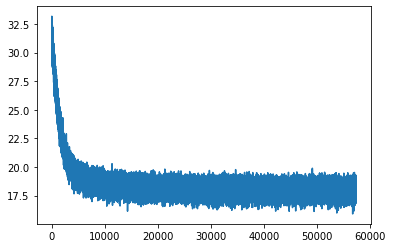

In [44]:
plt.figure()
plt.plot(losses)
plt.show()

In [58]:
i = 30000 # program we are testing
task = QuantumTask(i,lambda n_qubit, program=matched_programs[i]: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(n_qubit)))
code =  dc.program.Program.parse(matched_programs[i][1])
embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)
grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)


(-31.13456238488501, tensor([-21.1418], grad_fn=<AddBackward0>))

In [64]:
print_circuit(dc.program.Program.parse(matched_programs[-100][1]).evaluate([])(no_op(4)))

          ┌───┐     ┌───┐     ┌───┐     
q_0: ──■──┤ H ├──■──┤ X ├─────┤ X ├─────
     ┌─┴─┐└───┘┌─┴─┐└─┬─┘┌───┐└─┬─┘┌───┐
q_1: ┤ X ├─────┤ X ├──■──┤ H ├──■──┤ X ├
     ├───┤     └───┘     └───┘     └─┬─┘
q_2: ┤ H ├───────────────────────────■──
     └───┘                              
q_3: ───────────────────────────────────
                                        


In [48]:
task = get_task_from_name("cnot_10",tasks)
code = dc.program.Program.parse("(lambda (cnot (minv(mv( $0)))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-7.783640596221253, tensor([-7.5153], grad_fn=<AddBackward0>))

In [49]:
task = get_task_from_name("swap_01",tasks)
code = dc.program.Program.parse("(lambda  (cnot(minv(mv_r(cnot(minv (mv (cnot  $0))))))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-15.567281192442506, tensor([-14.8475], grad_fn=<AddBackward0>))

In [50]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda ((cnot(minv(mv_r(cnot(minv (mv (cnot(mv_r $0)))))))))) )  (mv_r( (rep (dec(size $0)) (lambda (mv((cnot(minv(mv_r(cnot(minv (mv (cnot $0)))))))))) )  $0 )))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-55.01960974404685, tensor([-58.8272], grad_fn=<AddBackward0>))

In [26]:
task.logLikelihood(code)

0.0

In [ ]:
# check performance of BagOfWords
# improve recognition model -> GREAT
# use prefix matching for full tasks to train also on more complex tasks 
#   i.e. look for programs that solve the circuit up to a certain gate_i within a given timeout
# CHANGE WAY IN WHICH OBSERVATIONAL EQUIVALENCE IS CHECKED SO THAT 'REP' OPERATIONS ARE ALLOWED AGAIN

#### Enumerating arithmetic

In [ ]:
counter = 0
for i in iterator:
    counter +=1
    if counter<100:
        print(i)
    else: break

[(lambda 0)]


(lambda $0)
(lambda (inc $0))
(lambda (dec $0))
(lambda (inc (inc $0)))
(lambda (dec (dec $0)))
(lambda (inc (inc (inc $0))))
(lambda (dec (dec (dec $0))))
(lambda (inc (inc (inc (inc $0)))))
(lambda (dec (dec (dec (dec $0)))))
(lambda (inc (inc (inc (inc (inc $0))))))
(lambda (dec (dec (dec (dec (dec $0))))))
(lambda (inc (inc (inc (inc (inc (inc $0)))))))
(lambda (dec (dec (dec (dec (dec (dec $0)))))))
(lambda (inc (inc (inc (inc (inc (inc (inc $0))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec $0))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc $0)))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec (dec $0)))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc (inc $0))))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec (dec (dec $0))))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc (inc (inc $0)))))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec (dec (dec (dec $0)))))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc (inc (inc (inc $0))))))))))))
(lambda (d

### Program matching

In [ ]:
restricted_pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tcircuit, tcircuit))
# print(restricted_pcfg)
restricted_dictionary = dc.enumeration.enumerate_pcfg(restricted_pcfg,timeout=60, circuit_execution_function=state_circuit_to_mat,no_op=no_op)

[(lambda 0)]


exception (lambda (mv_r $0))
exception (lambda (mv (mv (mv $0))))
exception (lambda (cnot (mv (mv $0))))
exception (lambda (mv (mv (mv (minv $0)))))
exception (lambda (mv (mv (mv (h $0)))))
exception (lambda (mv (mv (mv (cnot $0)))))
exception (lambda (mv (mv (h (mv $0)))))
exception (lambda (mv (mv (cnot (mv $0)))))
exception (lambda (mv (h (mv (mv $0)))))
exception (lambda (mv (cnot (mv (mv $0)))))
exception (lambda (mv_r (cnot (mv (mv $0)))))
exception (lambda (minv (cnot (mv (mv $0)))))
exception (lambda (h (mv (mv (mv $0)))))
exception (lambda (h (cnot (mv (mv $0)))))
exception (lambda (cnot (mv (mv (h $0)))))
exception (lambda (cnot (mv (mv (cnot $0)))))
exception (lambda (cnot (mv (h (mv $0)))))
exception (lambda (cnot (mv (cnot (mv $0)))))
exception (lambda (cnot (h (mv (mv $0)))))
exception (lambda (mv (mv (mv (minv (h $0))))))
exception (lambda (mv (mv (mv (minv (cnot $0))))))
exception (lambda (mv (mv (mv (h (cnot $0))))))
exception (lambda (mv (mv (mv (cnot (h $0))))))
exce

Enumerated 6124 programs


In [ ]:
full_pcfg = dc.grammar.PCFG.from_grammar(full_grammar, request=dc.type.arrow(tcircuit_full, tcircuit_full))
full_dictionary = dc.enumeration.enumerate_pcfg(full_pcfg,timeout=60, circuit_execution_function=full_circuit_to_mat, no_op=f_no_op)

[(lambda 0)]
Enumerated 4872 programs


In [ ]:
matched_programs = []
for unitary in full_dictionary.keys():
    if unitary in restricted_dictionary.keys():
        try:
            full_task = full_dictionary[unitary]["task"]
            full_unitary = full_circuit_to_mat(dc.program.Program.parse(full_task).evaluate([])(f_no_op(4)))
            
            restricted_task = restricted_dictionary[unitary]["task"]
            restricted_unitary = state_circuit_to_mat(dc.program.Program.parse(restricted_task).evaluate([])(no_op(4)))

            if np.all(full_unitary==restricted_unitary):
                matched_programs.append([full_task, 
                                         restricted_task, 
                                         max(full_dictionary[unitary]["time"],restricted_dictionary[unitary]["time"])])
        except QuantumCircuitException:
            ...
eprint(f"Enumerated {len(matched_programs)} programs")
# how long it took to enumerate (when the program was found)

Enumerated 1837 programs


In [ ]:
full_grammar.productions

[(0.0, tcircuit_full -> int -> tcircuit_full, fh),
 (0.0, tcircuit_full -> int -> int -> tcircuit_full, fcnot),
 (0.0, tcircuit_full -> int -> int -> tcircuit_full, fswap),
 (0.0, int, 0),
 (0.0, int -> int, inc),
 (0.0, int -> int, dec),
 (0.0, tcircuit_full -> int, fsize)]

#### GREAT feature for recognition model

In [ ]:
import dreamcoder.great

In [ ]:
feature_extr = dc.great.Great(layers=4, d_model=128)